## Métricas e Validação do modelo


Vamos explorar um conjunto de dados diferentes: uma base de vinhos; separar os dados e verificar como a mudança de parâmetros afeta o resultado. Há uma forma automatizada de fazer isso, mas isso será conteúdo do próximo encontro. Por enquanto, vamos fazer tudo manualmente para entender o processo.

In [1]:
from sklearn.datasets import load_wine
wine = load_wine()

data = wine.data
target = wine.target

In [2]:
# separando os dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

# separando o conjunto de treino em validação também
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [3]:
# treinando o modelo 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# avaliando o modelo
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_val)
print("Acurácia: ", accuracy_score(y_val, y_pred))

Acurácia:  0.65


In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Gabarito')
    plt.xlabel('Predição')
    plt.tight_layout()


# calcula a matriz de confusão
cnf_matrix = confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# não normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.unique(wine.target),
                      title='Matriz de confusão sem normalização')

# normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.unique(wine.target), normalize=True,
                      title='Matriz de confusão normalizada')

plt.show()

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

In [5]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.64      0.60      0.62        15
           2       0.50      0.58      0.54        12

   micro avg       0.65      0.65      0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40



In [6]:
# grid search

best_model = None
best_accuracy = 0

for k in [1,2,3,4,5]:

    knn = KNeighborsClassifier(n_neighbors = k) # a cada passo, o parâmetro assume um valor
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print('K:', k, '- ACC:', acc)
    
    if acc > best_accuracy:
        best_model = knn
        best_accuracy = acc
        
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print()
print('Melhor modelo:')
print('K:', best_model.get_params()['n_neighbors'], '- ACC:', acc * 100)

print(classification_report(y_test, y_pred))

K: 1 - ACC: 0.725
K: 2 - ACC: 0.675
K: 3 - ACC: 0.65
K: 4 - ACC: 0.625
K: 5 - ACC: 0.675

Melhor modelo:
K: 1 - ACC: 77.96610169491525
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.79      0.79      0.79        24
           2       0.60      0.60      0.60        15

   micro avg       0.78      0.78      0.78        59
   macro avg       0.76      0.76      0.76        59
weighted avg       0.78      0.78      0.78        59



In [7]:
# embaralhando os dados várias vezes e re-executando o experimento

import numpy as np
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # 5 execuções diferentes com 20% dos dados para teste

acc = []
for train_index, test_index in ss.split(data):
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(data[train_index],target[train_index])
    y_pred = knn.predict(data[test_index])
    acc.append(accuracy_score(y_pred,target[test_index]))

acc = np.asarray(acc) # converte pra numpy pra ficar mais simples de usar média e desvio padrão
print('Acurácia: %.2f +- %.2f' % (acc.mean() * 100, acc.std() * 100))

Acurácia: 71.11 +- 8.89


In [8]:
# utilizando validação cruzada com cross_val_score
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors = 1)
scores = cross_val_score(knn, data, target, cv=5) # 5 execuções diferentes com 20% dos dados para teste

print('Acurácia: %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))

Acurácia: 72.53 +- 6.56


In [9]:
# utilizando validação cruzada com KFold

from sklearn.model_selection import KFold
kf = KFold(n_splits = 5)

acc = []
for train_index, test_index in kf.split(data):
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(data[train_index],target[train_index])
    y_pred = knn.predict(data[test_index])
    acc.append(accuracy_score(y_pred,target[test_index]))

acc = np.asarray(acc) # converte pra numpy pra ficar mais simples de usar média e desvio padrão
print('Acurácia: %.2f +- %.2f' % (acc.mean() * 100, acc.std() * 100))

Acurácia: 63.33 +- 23.70


In [10]:
# utilizando validação cruzada com KFold estratificado

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 5)

acc = []
for train_index, test_index in kf.split(data, target): # precisa passar as classes agora para que a divisão aconteça
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(data[train_index],target[train_index])
    y_pred = knn.predict(data[test_index])
    acc.append(accuracy_score(y_pred,target[test_index]))

acc = np.asarray(acc) # converte pra numpy pra ficar mais simples de usar média e desvio padrão
print('Accuracy - %.2f +- %.2f' % (acc.mean() * 100, acc.std() * 100))

Accuracy - 72.53 +- 6.56


Text(0.5, 1.0, 'PCA of WINE dataset')

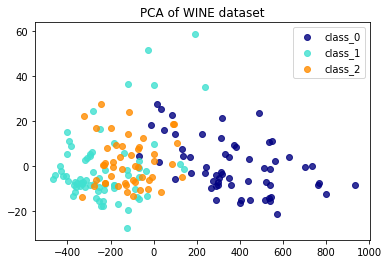

In [11]:
# visualizacao dos dados para entender a complexidade

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_r = pca.fit_transform(data)

colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], wine.target_names):
    plt.scatter(X_r[target == i, 0], X_r[target == i, 1], color=color, alpha=.8, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of WINE dataset')

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(data)
data_s = scaler.transform(data)

df = pd.DataFrame(data_s)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,7.841418e-15,2.444986e-16,-4.059175e-15,-7.110417e-17,-2.494883e-17,-1.955365e-16,9.443133e-16,-4.178929e-16,-1.540590e-15,-4.129032e-16,1.398382e-15,2.126888e-15,-6.985673e-17
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246e+00,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-8.854682e-01,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,9.595986e-02,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,8.089974e-01,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515e+00,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(data_s)

colors = ['navy', 'turquoise', 'darkorange']
for color, i, target_name in zip(colors, [0, 1, 2], wine.target_names):
    plt.scatter(X_r[target == i, 0], X_r[target == i, 1], color=color, alpha=.8, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of WINE dataset')

Os dados agora estão todos muito próximos de 0 com desvio padrão 1, e isso melhora a disposição gráfica como pode ser visto na imagem. Não há mais tanto aglomeração, e existe separações lineares mais visíveis. Isso são fortes indícios de que agora um método de aprendizagem terá melhor desempenho. No entanto, enquanto para visualizar o StandardScaler foi aplicado em toda a base, é importante perceber que ao testar o modelo, **o StandardScaler só pode ter dados de treino no fit**. Ou seja, ele não pode conhecer a disposição dos dados de teste.

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 5)

acc = []
for train_index, test_index in kf.split(data, target): # precisa passar as classes agora para que a divisão aconteça
    knn = KNeighborsClassifier(n_neighbors = 1)
    
    scaler = StandardScaler()
    train = scaler.fit_transform(data[train_index]) # somente dados de treino no fit
    test = scaler.transform(data[test_index]) # aplica-se transform no teste apenas
    
    knn.fit(train,target[train_index])
    y_pred = knn.predict(test)
    acc.append(accuracy_score(y_pred,target[test_index]))

acc = np.asarray(acc) # converte pra numpy pra ficar mais simples de usar média e desvio padrão
print('Acurácia: %.2f +- %.2f' % (acc.mean() * 100, acc.std() * 100))

In [ ]:
# utilizando validação cruzada com cross_val_score

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
scores = cross_val_score(pipeline, data, target, cv=5) # 5 execuções diferentes com 20% dos dados para teste

print('Acurácia: %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))

In [ ]:
# separa-se uma parcela para encontrar os melhores parâmetros (10% do original)
data_gs, data_cv, target_gs, target_cv = train_test_split(data, target, test_size=0.9, random_state=42, stratify=target)

# uma forma automática de StandardScaler + KNN
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])

# utiliza-se GridSearchCV para achar os melhores parâmetros
from sklearn.model_selection import GridSearchCV
parameters = {'clf__n_neighbors': [1,2,3,4,5], 'clf__weights' : ['uniform','distance']} # quais parâmetros e quais valores serão testados
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False) # clf vai armazenar qual foi a melhor configuração
clf.fit(data_gs, target_gs)

# utilizando validação cruzada para avaliar o modelo
scores = cross_val_score(clf, data_cv, target_cv, cv=5)

print('Acurácia: %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))

# Desafio - Instruções

* Com o conjunto de dados sobre *câncer de mama*, utilize a célula seguinte com os dados carregados e divididos e **obtenha o melhor desempenho em um balanceamento das métricas**. 

* O modelo criado por você deverá ser *testado no conjunto de teste X_test e y_test*. 

* *O conjunto data_train e target_train poderá ser utilizado para escolher os melhores parâmetros e validar o modelo.*

* Organize e **tenha cuidado** para que seu experimento execute um *protocolo de validação que faça sentido*.

Mais informações sobre esse conjunto de dados poderão ser obtidas em: 
[https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset](http://)

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target

X_train, y_test, X_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)